<a href="https://colab.research.google.com/github/Z4HRA-S/GAN-vs-MiniBatch-GAN/blob/master/CIFAR_GANvsMGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Comparison of GAN with miniBatch GAN**
#### Deep Learning course - IASBS

In this exercise, a GAN and a MiniBatch GAN are implemented in Keras for MNIST and CFar10 image datasets.
This comparison code has been developed with help of multipule good references and webpages including:

- Goodfellow, Ian. "NIPS 2016 tutorial: Generative adversarial networks." arXiv preprint arXiv:1701.00160 (2016).
- Salimans, Tim, et al. "Improved techniques for training gans." Advances in neural information processing systems. 2016.
- Gündisch, David, Writing your first generative adversarial network with keras, 20 Sep 2019 [link](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)
- Brownlee, Jason, How to Code the GAN Training Algorithm and Loss Functions, 12 July 2019 [link](https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/)
- Hui,Jonathan, Ways to improve GAN performance, 19 Jun 2018 [link](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)


In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 44kB/s 
     |████████████████████████████████| 512kB 36.3MB/s 
     |████████████████████████████████| 3.8MB 37.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=eb88fd8946cb54316687c5889fe962ff56925a03c6e2f8c95884cce72d76029f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: 

Importing dependencies


In [2]:
from keras import backend as K
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2D
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

Using TensorFlow backend.


In [3]:
# generate mode in dataset
(x_train, y_train),(_,_)=cifar10.load_data()
y_train= y_train.flatten()
imbalanced_dataset=np.empty((1,x_train.shape[1],x_train.shape[2],3))
for i in set(y_train):
  x_train_i = np.array(x_train[y_train == i])
  if i != 4: 
    x_train_i = x_train_i[:int(len(x_train_i)/2)]
  print(i,":",len(x_train_i))
  imbalanced_dataset=np.concatenate((imbalanced_dataset , x_train_i))
np.random.shuffle(imbalanced_dataset)
print(len(imbalanced_dataset))


170500096/170498071 [==============================] - 2s 0us/step
0 : 2500
1 : 2500
2 : 2500
3 : 2500
4 : 5000
5 : 2500
6 : 2500
7 : 2500
8 : 2500
9 : 2500
27501


Minibatch Discrimination Layer

In [4]:
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints

# From a PR that is not pulled into Keras
# https://github.com/fchollet/keras/pull/3677
# I updated the code to work on Keras 2.x

class MinibatchDiscrimination(Layer):
    def __init__(self, nb_kernels, kernel_dim, init='random_normal', weights=None,input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),shape=(None, input_dim))]
        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
        initializer=self.init,
        name='kernel',
        trainable=True)
        # Set built to true.
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                      'kernel_dim': self.kernel_dim,
                      'init': self.init.__name__,
                      'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
class GAN():
    def __init__(self, minibatch = False):
        self.minibatch = minibatch
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.generator = self.build_generator()

        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        self.discriminator.trainable = False

        validity = self.discriminator(img)

        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
        
    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(3, (1,1), padding="valid", input_shape=self.img_shape))
        model.add(Conv2D(64, (3,3), border_mode='same'))
        # model.add(Flatten(input_shape=self.img_shape))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        if self.minibatch:
            model.add(MinibatchDiscrimination(5,3))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    def train(self, epochs, batch_size=128, sample_interval=50):
        #(X_train, _), (_, _) = mnist.load_data()
        X_train = imbalanced_dataset
        X_train = X_train / 127.5 - 1.
        ####
        #X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % sample_interval == 0:
               self.sample_images(epoch)
    def sample_images(self, epoch):
            r, c = 5, 5
            noise = np.random.normal(0, 1, (r * c, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(r, c)
            cnt = 0
            for i in range(r):
                for j in range(c):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                    axs[i,j].axis('off')
                    cnt += 1
            #fig.savefig("images/%d.png" % epoch)
            plt.show()
            plt.close()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33554944  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 2.433977, acc.: 50.00%] [G loss: 3.706947]


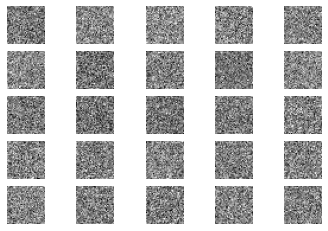

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.725597, acc.: 51.14%] [G loss: 1.027164]
2 [D loss: 0.129216, acc.: 98.48%] [G loss: 1.741717]
3 [D loss: 0.028561, acc.: 99.62%] [G loss: 2.016830]
4 [D loss: 0.136929, acc.: 95.08%] [G loss: 4.253550]
5 [D loss: 0.019258, acc.: 99.62%] [G loss: 3.716803]
6 [D loss: 0.071058, acc.: 96.97%] [G loss: 2.268113]
7 [D loss: 0.057468, acc.: 97.73%] [G loss: 2.422496]
8 [D loss: 0.062006, acc.: 98.48%] [G loss: 2.850911]
9 [D loss: 0.064371, acc.: 97.73%] [G loss: 3.738436]
10 [D loss: 0.072921, acc.: 97.73%] [G loss: 3.379660]
11 [D loss: 0.133019, acc.: 94.70%] [G loss: 5.233290]
12 [D loss: 0.081837, acc.: 98.11%] [G loss: 4.604303]
13 [D loss: 0.117507, acc.: 96.59%] [G loss: 5.079857]
14 [D loss: 0.078076, acc.: 99.24%] [G loss: 4.595122]
15 [D loss: 0.084248, acc.: 98.86%] [G loss: 4.732833]
16 [D loss: 0.069042, acc.: 98.86%] [G loss: 4.785554]
17 [D loss: 0.067826, acc.: 99.62%] [G loss: 4.454033]
18 [D loss: 0.043069, acc.: 99.62%] [G loss: 4.517393]
19 [D loss: 0.04045

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


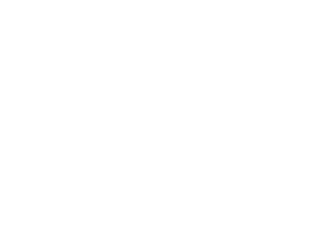

101 [D loss: nan, acc.: 50.00%] [G loss: nan]
102 [D loss: nan, acc.: 50.00%] [G loss: nan]
103 [D loss: nan, acc.: 50.00%] [G loss: nan]
104 [D loss: nan, acc.: 50.00%] [G loss: nan]
105 [D loss: nan, acc.: 50.00%] [G loss: nan]
106 [D loss: nan, acc.: 50.00%] [G loss: nan]
107 [D loss: nan, acc.: 50.00%] [G loss: nan]
108 [D loss: nan, acc.: 50.00%] [G loss: nan]
109 [D loss: nan, acc.: 50.00%] [G loss: nan]
110 [D loss: nan, acc.: 50.00%] [G loss: nan]
111 [D loss: nan, acc.: 50.00%] [G loss: nan]
112 [D loss: nan, acc.: 50.00%] [G loss: nan]
113 [D loss: nan, acc.: 50.00%] [G loss: nan]
114 [D loss: nan, acc.: 50.00%] [G loss: nan]
115 [D loss: nan, acc.: 50.00%] [G loss: nan]
116 [D loss: nan, acc.: 50.00%] [G loss: nan]
117 [D loss: nan, acc.: 50.00%] [G loss: nan]
118 [D loss: nan, acc.: 50.00%] [G loss: nan]
119 [D loss: nan, acc.: 50.00%] [G loss: nan]
120 [D loss: nan, acc.: 50.00%] [G loss: nan]
121 [D loss: nan, acc.: 50.00%] [G loss: nan]
122 [D loss: nan, acc.: 50.00%] [G

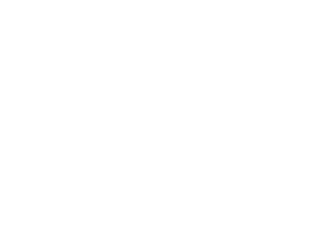

201 [D loss: nan, acc.: 50.00%] [G loss: nan]
202 [D loss: nan, acc.: 50.00%] [G loss: nan]
203 [D loss: nan, acc.: 50.00%] [G loss: nan]
204 [D loss: nan, acc.: 50.00%] [G loss: nan]
205 [D loss: nan, acc.: 50.00%] [G loss: nan]
206 [D loss: nan, acc.: 50.00%] [G loss: nan]
207 [D loss: nan, acc.: 50.00%] [G loss: nan]
208 [D loss: nan, acc.: 50.00%] [G loss: nan]
209 [D loss: nan, acc.: 50.00%] [G loss: nan]
210 [D loss: nan, acc.: 50.00%] [G loss: nan]
211 [D loss: nan, acc.: 50.00%] [G loss: nan]
212 [D loss: nan, acc.: 50.00%] [G loss: nan]
213 [D loss: nan, acc.: 50.00%] [G loss: nan]
214 [D loss: nan, acc.: 50.00%] [G loss: nan]
215 [D loss: nan, acc.: 50.00%] [G loss: nan]
216 [D loss: nan, acc.: 50.00%] [G loss: nan]
217 [D loss: nan, acc.: 50.00%] [G loss: nan]
218 [D loss: nan, acc.: 50.00%] [G loss: nan]
219 [D loss: nan, acc.: 50.00%] [G loss: nan]
220 [D loss: nan, acc.: 50.00%] [G loss: nan]
221 [D loss: nan, acc.: 50.00%] [G loss: nan]
222 [D loss: nan, acc.: 50.00%] [G

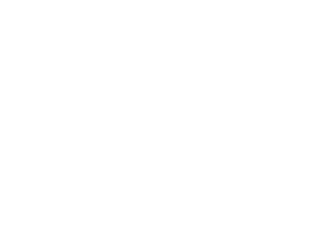

301 [D loss: nan, acc.: 50.00%] [G loss: nan]
302 [D loss: nan, acc.: 50.00%] [G loss: nan]
303 [D loss: nan, acc.: 50.00%] [G loss: nan]
304 [D loss: nan, acc.: 50.00%] [G loss: nan]
305 [D loss: nan, acc.: 50.00%] [G loss: nan]
306 [D loss: nan, acc.: 50.00%] [G loss: nan]
307 [D loss: nan, acc.: 50.00%] [G loss: nan]


KeyboardInterrupt: ignored

In [6]:
if __name__ == '__main__':
    gan = GAN(minibatch=True)
    gan.train(epochs=10000, batch_size=132, sample_interval=100)